# About the DataSet

__Containing 18,000 job descriptions, including around 800 flagged as fraudulent, this dataset offers a comprehensive collection of textual content and meta-information about job postings. It serves as a valuable resource for building machine learning models aimed at classifying fake job descriptions. By leveraging this dataset, we can develop models that enhance job platforms' ability to identify and filter out fraudulent job postings, ensuring a more trustworthy experience for job seekers.__

Dataset Source:https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction

# About the Project

__In an era of online job portals, the challenge of distinguishing between genuine and fraudulent job postings has emerged as a critical concern. This project addresses this challenge by leveraging machine learning to identify fake job descriptions from a dataset of 18,000 job postings. With around 800 flagged as fraudulent, we aim to develop a classification model that harnesses both textual content and metadata to accurately differentiate between authentic and fake job descriptions.__

![](fraud-prevention-3188092_960_720.jpg)


__Importing all the necessary libraries__

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from scipy.stats import chi2_contingency
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib inline
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as XGB 
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier

In [2]:
#Reading the Data
Job_postings=pd.read_csv('fake_job_postings.csv')

In [3]:
#Glance at the Data
Job_postings.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
#Looking out for the number of features available and their type.
Job_postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

__Setting the Agenda before starting the proceedings "Fraudulent" i.e Column 17 is going to Target Feature__

  __'0'-Genuine/Not a Fraud posting__

  __'1'-Fraud posting__

In [5]:
Job_postings.shape

(17880, 18)

In [6]:
Job_postings.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

# Starting with Null values of the Text features

In [7]:
Job_postings.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

__Initially thought of removing sample where majority of the text data is missing but looking at the above information if we do so we'll loose majority of the samples because of  which other features may loose their role in model construction__

In [8]:
Job_postings

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [9]:
Filling_values={'company_profile': ' ','description': ' ','requirements': ' ','benefits': ' '}

In [10]:
Job_postings.fillna(value=Filling_values,inplace=True)

In [11]:
Job_postings[{'company_profile','description','requirements','benefits'}].isnull().sum()

/var/folders/pq/ncc84cyn6cl7mhcszk5vx8900000gn/T/ipykernel_3551/2912796425.py:1: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



company_profile    0
requirements       0
benefits           0
description        0
dtype: int64

__Checking Whether the data is biased or not__

Text(0.5, 1.0, 'Total Job Postings')

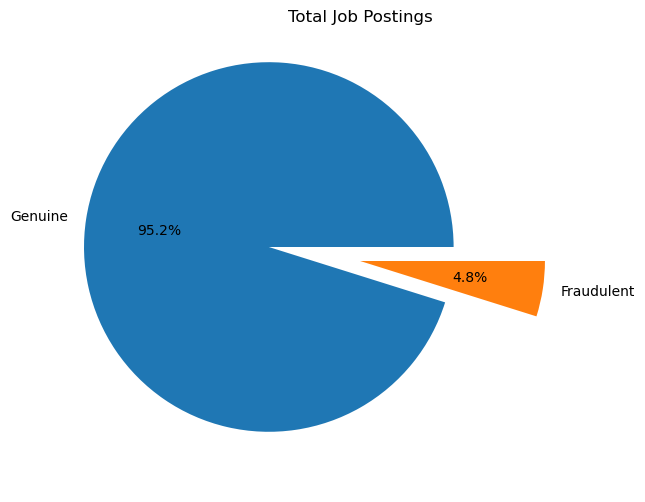

In [12]:
plt.figure(figsize=(10,6))
labels_=['Genuine','Fraudulent']
plt.pie(Job_postings['fraudulent'].value_counts(),labels=labels_,autopct='%1.1f%%',explode=(0.5,0))
plt.title("Total Job Postings")

__From the above plot it is clear that it is a unbalanced dataset__

# Exploratory Data Analysis

In [13]:
#There's nothing to do with job_id feature
Job_postings_=Job_postings.drop(columns='job_id',axis=1)

# Feature  "Location"

In [14]:
#Trimming the location feature and considering the country alone
Job_postings_['Location']=Job_postings['location'].str[0:2]

In [15]:
Job_postings_.drop(columns='location',axis=1,inplace=True)

In [16]:
Job_postings_

,title,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Location
0,Marketing Intern,Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US
1,Customer Service - Cloud Video Production,Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US
3,Account Executive - Washington DC,Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0,CA
17876,Payroll Accountant,Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US
17877,Project Cost Control Staff Engineer - Cost Con...,NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,0,0,0,Full-time,NaN,NaN,NaN,NaN,0,US
17878,Graphic Designer,NaN,NaN,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0,NG


In [21]:
#Creating a frequency distribution table
Countries=pd.DataFrame(Job_postings_fraud['Location'].value_counts())

In [22]:
Countries

,Location
US,730
AU,40
GB,23
MY,12
CA,12
QA,6
BH,5
IN,4
PL,3
TW,2


In [23]:
Country_freq_dict=Countries['Location']

In [24]:
wrdcld=WordCloud(width=800,height=400,background_color='black')

In [25]:
wrdcld.generate_from_frequencies(Country_freq_dict)

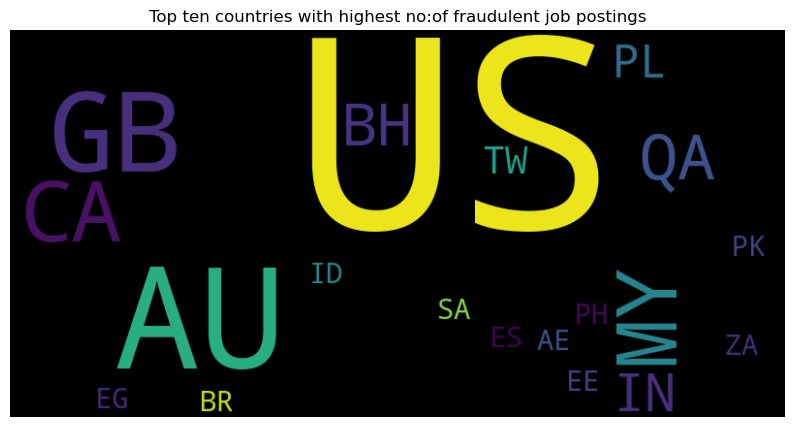

In [26]:
plt.figure(figsize=(10,8))
plt.imshow(wrdcld,interpolation='bilinear')
plt.title("Top ten countries with highest no:of fraudulent job postings")
plt.axis("off")
plt.show()

In [27]:
Job_postings_fraud=Job_postings_[Job_postings_['fraudulent']==1]

In [28]:
Top_ten_countries=Job_postings_fraud['Location'].value_counts().head(10)

In [29]:
Top_ten_countries

US    730
AU     40
GB     23
MY     12
CA     12
QA      6
BH      5
IN      4
PL      3
TW      2
Name: Location, dtype: int64

Text(0.5, 1.0, 'Top ten countries with most number of Fraudulent job postings')

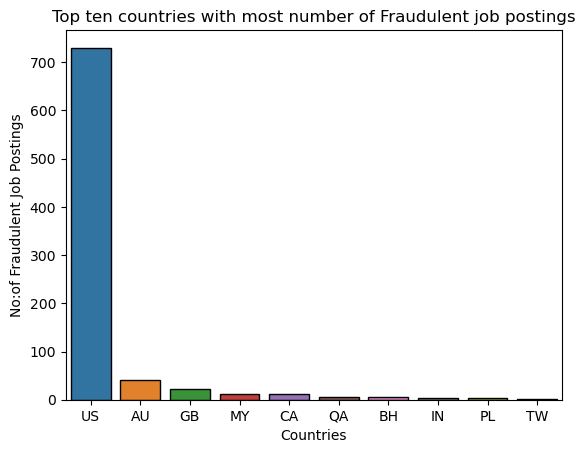

In [30]:
sns.barplot(x=Top_ten_countries.index,y=Top_ten_countries.values,edgecolor='black')
plt.xlabel('Countries')
plt.ylabel('No:of Fraudulent Job Postings')
plt.title("Top ten countries with most number of Fraudulent job postings")

__The number of missing samples is quite less when compared to the size of dataset.Therefore dropping those samples__

In [31]:
Job_postings_.dropna(subset=['Location'],inplace=True)

In [32]:
Top_Ten_Countries={'Country':Top_ten_countries.index,'No:of fraudulent job postings':Top_ten_countries.values}

In [33]:
Top_Ten_Countries=pd.DataFrame(Top_Ten_Countries)

# Salary range

__In reality many job postings mention about salary and many doesn't.So it is not going to play any crucial role in the construction of model__

In [35]:
Job_postings_.drop(columns='salary_range',axis=1,inplace=True)

# Title

In [36]:
Job_postings_['title'].nunique()

10972

In [37]:
Top_ten_job_titles=Job_postings_fraud['title'].value_counts().head(10)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Data Entry Admin/Clerical Positions - Work From Home'),
  Text(1, 0, 'Home Based Payroll Typist/Data Entry Clerks Positions Available'),
  Text(2, 0, 'Cruise Staff Wanted *URGENT*'),
  Text(3, 0, 'Customer Service Representative'),
  Text(4, 0, 'Administrative Assistant'),
  Text(5, 0, 'Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily '),
  Text(6, 0, 'Account Sales Managers $80-$130,000/yr'),
  Text(7, 0, 'Network Marketing'),
  Text(8, 0, 'Payroll Clerk'),
  Text(9, 0, 'Payroll Data Coordinator Positions - Earn $100-$200 Daily ')])

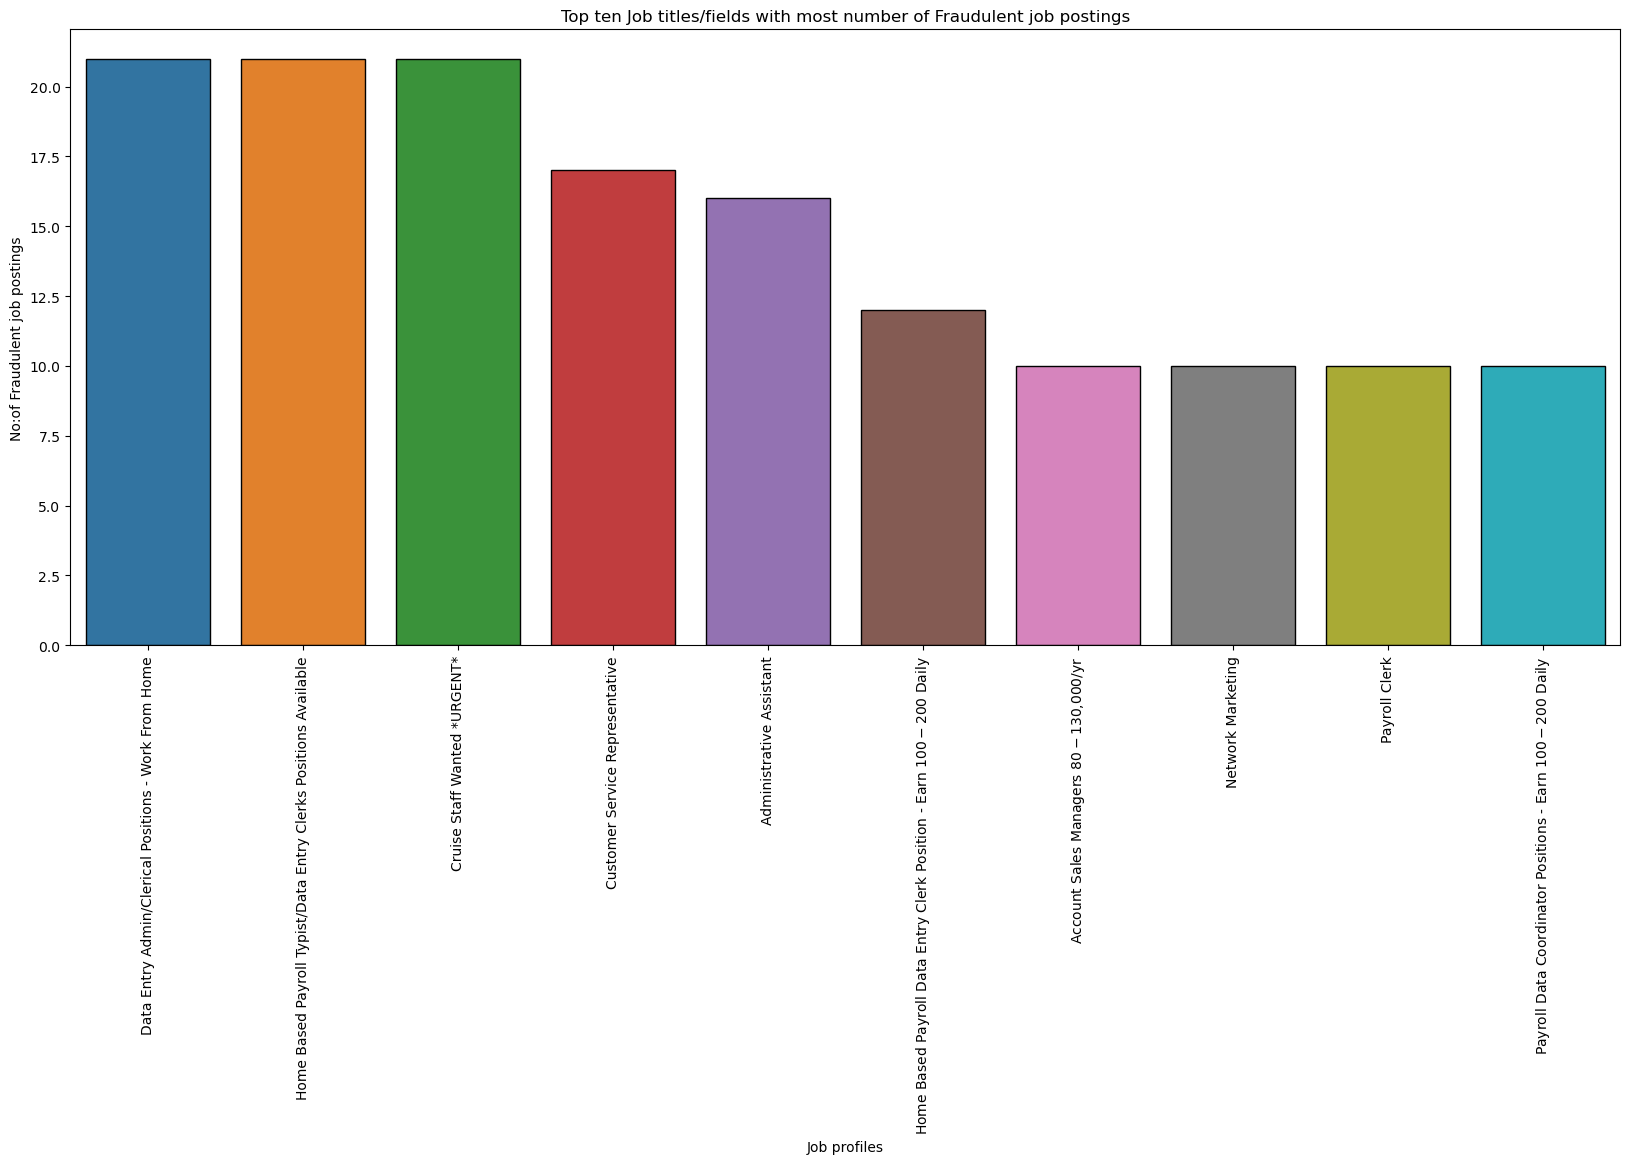

In [38]:
plt.figure(figsize=(20,8))
sns.barplot(x=Top_ten_job_titles.index,y=Top_ten_job_titles.values,edgecolor='black')
plt.xlabel('Job profiles')
plt.ylabel('No:of Fraudulent job postings')
plt.title("Top ten Job titles/fields with most number of Fraudulent job postings")
plt.xticks(rotation=90)

In [39]:
def chitest(column):
    # Create the contingency table
    tab = pd.crosstab(Job_postings_[column], Job_postings_['fraudulent'])

    # Perform the chi-squared test
    chi2, p_value, _, _ = chi2_contingency(tab)

    print('Chi-squared value:', chi2)
    print('p-value:', p_value)


In [40]:
chitest('department')

Chi-squared value: 3697.813550598989
p-value: 9.600179786995432e-223


# Employment type

In [41]:
Job_postings_['employment_type'].nunique()

5

<Axes: xlabel='employment_type', ylabel='count'>

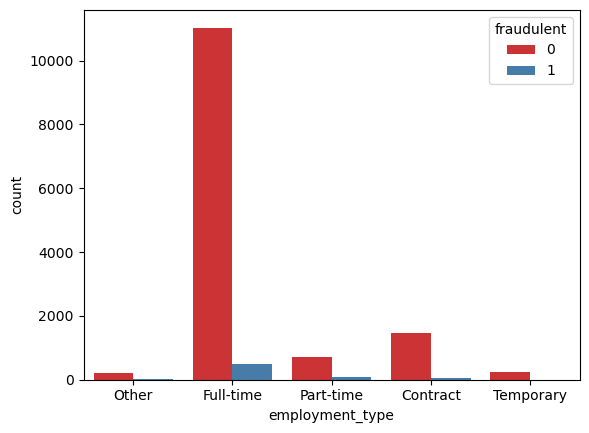

In [42]:
sns.countplot(x='employment_type',data=Job_postings_,hue='fraudulent',palette='Set1')

In [43]:
Job_postings_[(Job_postings_['employment_type']=='Temporary') & (Job_postings_['fraudulent']==1)]

,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Location
6128,Accounting/Bookkeeping,NaN,,"Hello Applicant,What is your situation? Are yo...",,,0,0,0,Temporary,Entry level,Unspecified,Accounting,Accounting/Auditing,1,US
17758,Personal Assistant,Admin - Clerical,,Job DescriptionVertex Global Solutions seeks ...,,,0,0,0,Temporary,Entry level,Unspecified,Telecommunications,Administrative,1,US


In [44]:
Job_postings_[(Job_postings_['employment_type']=='Contract') & (Job_postings_['fraudulent']==1)]

,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Location
357,Financing Auto(car) sales,hr,Looking for adventurous people to join a thriv...,If you have experience in financing for auto s...,prior car sales expprior car loan financing exp,profit sharingcar allowancecompany car,0,0,0,Contract,Associate,NaN,Automotive,NaN,1,US
859,Executive/Head Chef,NaN,Le Meridien is situated in the heart of kuala ...,Responsible for all food production including ...,Skills and Specifications: * Must have a pa...,,0,1,0,Contract,Executive,NaN,Hospitality,NaN,1,MY
997,EXECUTIVE SOUS CHEF,NaN,Le Meridien is situated in the heart of kuala ...,Responsible for assisting in the direction and...,,,0,1,0,Contract,Executive,NaN,Hospitality,NaN,1,MY
1202,Big Data Engineer,NaN,,Position: Big Data EngineerLocation: San Fran...,Responsibilities:Ability to analyze business n...,,0,0,0,Contract,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,1,US
1420,Informatica/ Etl Tester,IT,,Position: Informatica Tester Location: Herndo...,,,0,0,0,Contract,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,1,US
2444,Urgent Requirement For The Position Technical ...,NaN,,1. Technical Lead - Rhomobile Technical Mob...,Requirement / JD: Drive the mobile app develop...,,0,0,1,Contract,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,1,US
2750,Administrative Assistant,Administrative,"AZCO INC. is an employee-owned, full service i...","We are currently looking for someone , respon...",Minimum of one year administrative assistant e...,"Health, Dental &amp; Vision Benefits after 6 m...",0,1,0,Contract,Entry level,Bachelor's Degree,Construction,Administrative,1,US
3320,Food and Beverage Director,NaN,,You will be responsible for directing the outl...,"Computer Skills: Proficient with,* MS Outlook*...",,0,0,0,Contract,NaN,NaN,NaN,NaN,1,MY
3367,Executive Chef,NaN,,Responsible for all food production including ...,Skills and Specifications:* Must have a passio...,,0,0,0,Contract,Executive,NaN,Hospitality,NaN,1,MY
3711,software development life cycle,NaN,,Title: Service Desk ResourceLocation: Atlant...,Position Requirements: Experience supporting a...,,0,1,1,Contract,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,1,US


In [45]:
Job_postings_[Job_postings_['fraudulent']==1]

,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Location
98,IC&E Technician,Oil & Energy,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abilitie...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1,US
173,Technician Instrument & Controls,Power Plant & Energy,Edison International and Refined Resources hav...,Technician Instrument &amp; ControlsLocation D...,JOB QUALIFICATIONS-Ability to understand proce...,"we are a team of almost 8,000 employees who he...",0,1,1,Full-time,Mid-Senior level,Certification,Electrical/Electronic Manufacturing,Other,1,US
180,Sales Executive,Sales,,Sales Executive,Sales Executive,Sales Executive,0,0,0,NaN,NaN,NaN,NaN,Sales,1,PK
215,IC&E Technician Mt Poso,Oil & Energy,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abiliti...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1,US
357,Financing Auto(car) sales,hr,Looking for adventurous people to join a thriv...,If you have experience in financing for auto s...,prior car sales expprior car loan financing exp,profit sharingcar allowancecompany car,0,0,0,Contract,Associate,NaN,Automotive,NaN,1,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17827,Student Positions Part-Time and Full-Time.,NaN,,Student Positions Part-Time and Full-Time.You ...,,,0,0,0,Part-time,NaN,NaN,NaN,NaN,1,US
17828,Sales Associate,Sales and Marketing,,LEARN TO EARN AN EXECUTIVE LEVEL INCOMEFULL TR...,What You Can Do. • Have the potential to earn ...,Who We Are We are a Global Leadership Developm...,0,0,1,NaN,NaN,NaN,NaN,NaN,1,AU
17829,Android Developer,NaN,,inFullMobile Sp. z o.o. is a mobile software d...,• A proven track record in Android / JAVA proj...,attractive salary (adequate to the candidate s...,0,0,0,NaN,NaN,NaN,NaN,NaN,1,PL
17830,Payroll Clerk,NaN,,JOB DESCRIPTIONWe are seeking a full time payr...,JOB REQUIREMENTS• High school diploma or eq...,We offer a competitive salary and benefits pac...,0,0,0,Full-time,NaN,NaN,Apparel & Fashion,Accounting/Auditing,1,US


# Department

In [46]:
Job_postings_['department'].value_counts().head(10)

Sales                     547
Engineering               486
Marketing                 396
Operations                270
IT                        221
Development               145
Product                   112
Information Technology     86
Design                     75
Technology                 75
Name: department, dtype: int64

In [47]:
Job_postings_['department'].nunique()

1326

In [48]:
Job_postings_fraud['department'].nunique()

103

In [49]:
Top_ten_departments=Job_postings_fraud['department'].value_counts().head(10)

In [50]:
Top_ten_departments

Engineering                46
Clerical                   27
Oil & Energy               24
Information Technology     15
Administrative             14
Customer Service           14
Information Technology     12
Sales                      12
Engineering                 9
admin                       7
Name: department, dtype: int64

In [51]:
Top_Ten_departments={'Department':Top_ten_departments.index,'No:of fraud postings':Top_ten_departments.values}

In [52]:
Top_Ten_departments=pd.DataFrame(Top_Ten_departments)

In [53]:
Top_Ten_departments

,Department,No:of fraud postings
0,Engineering,46
1,Clerical,27
2,Oil & Energy,24
3,Information Technology,15
4,Administrative,14
5,Customer Service,14
6,Information Technology,12
7,Sales,12
8,Engineering,9
9,admin,7


In [117]:
plt.figure(figsize=(20,6))
Top_Ten_departments.iplot(kind='bar',x='Department',y='No:of fraud postings')


<Figure size 2000x600 with 0 Axes>

# Industry

In [55]:
#Top ten Industries with highest no:of job postings
Job_postings_['industry'].value_counts().head(10)

Information Technology and Services    1718
Computer Software                      1364
Internet                               1048
Education Management                    822
Marketing and Advertising               821
Financial Services                      774
Hospital & Health Care                  495
Consumer Services                       357
Telecommunications                      340
Oil & Energy                            285
Name: industry, dtype: int64

In [56]:
Top_ten_industries=Job_postings_fraud['industry'].value_counts().head(10)

In [57]:
Top_ten_industries

Oil & Energy                           109
Accounting                              57
Hospital & Health Care                  51
Marketing and Advertising               45
Financial Services                      35
Information Technology and Services     32
Telecommunications                      26
Real Estate                             24
Consumer Services                       24
Leisure, Travel & Tourism               21
Name: industry, dtype: int64

Text(0.5, 1.0, 'Top ten industries with highest no:of fraudulent job postings')

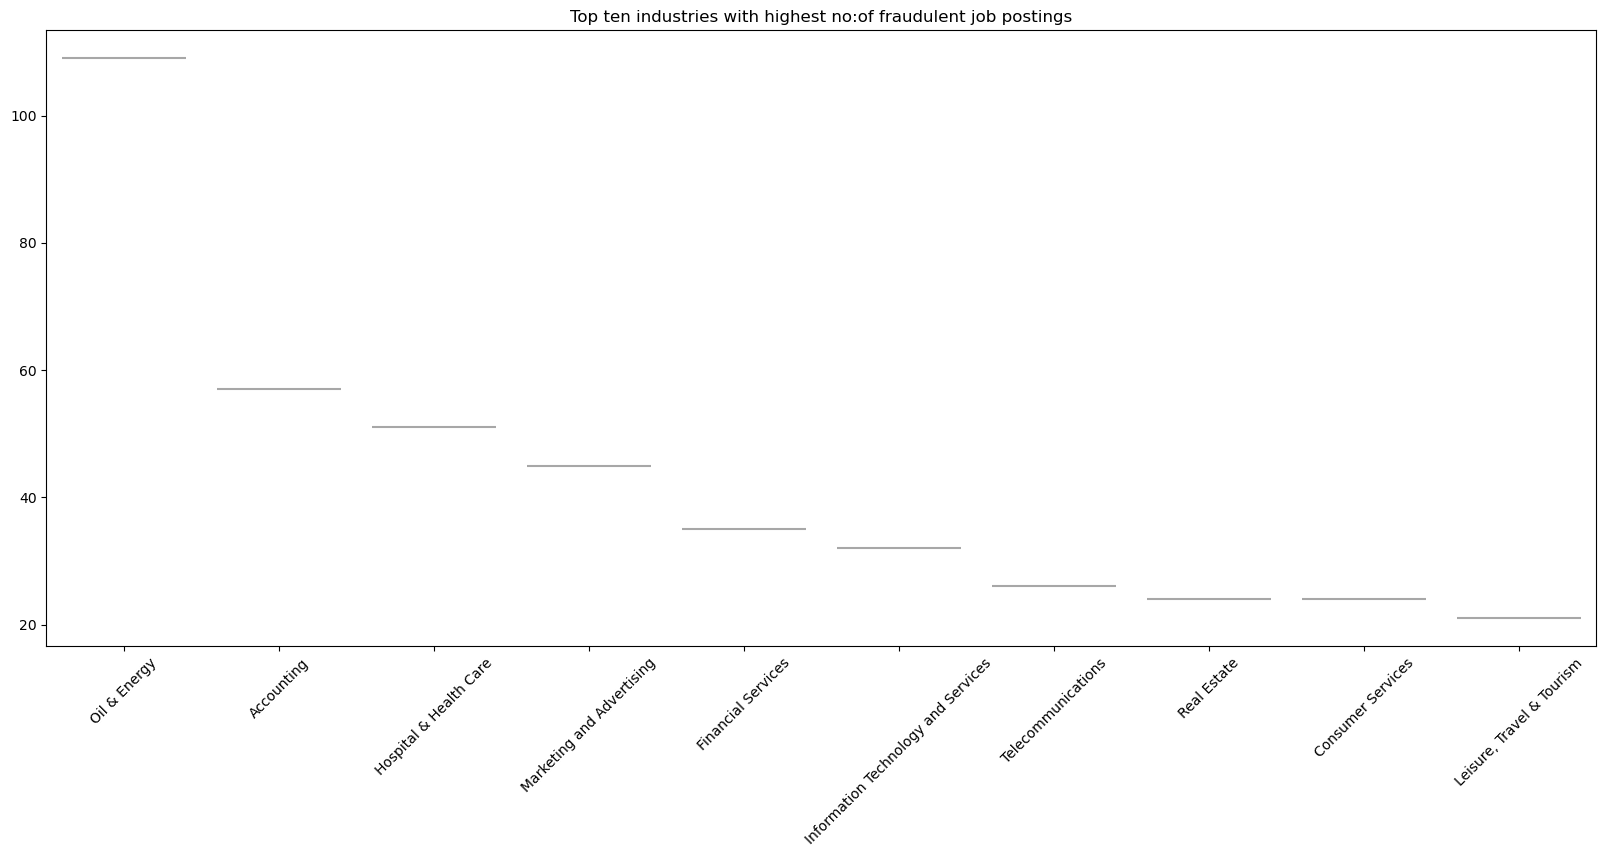

In [58]:
plt.figure(figsize=(20,8))
sns.boxenplot(x=Top_ten_industries.index,y=Top_ten_industries.values,data=Job_postings_fraud)
plt.xticks(rotation=45)
plt.title("Top ten industries with highest no:of fraudulent job postings")

# Telecommunicating

In [59]:
Job_postings['telecommuting'].nunique()

2

Text(0.5, 1.0, "fraudulent job posting's telecommuting offerings")

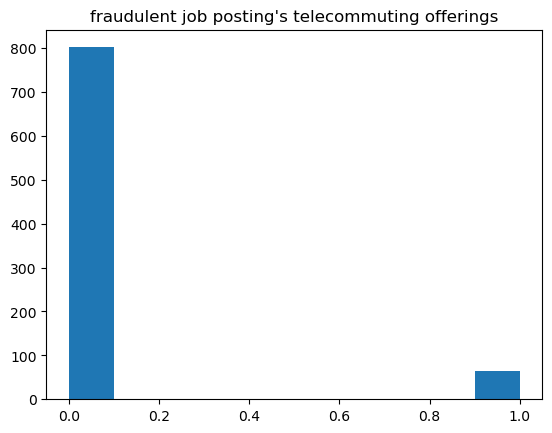

In [60]:
Job_postings_fraud['telecommuting'].hist(grid=False)
plt.title("fraudulent job posting's telecommuting offerings")

# Company Logo

In [61]:
Job_postings_fraud['has_company_logo'].value_counts()

0    583
1    283
Name: has_company_logo, dtype: int64

<Axes: xlabel='has_company_logo', ylabel='count'>

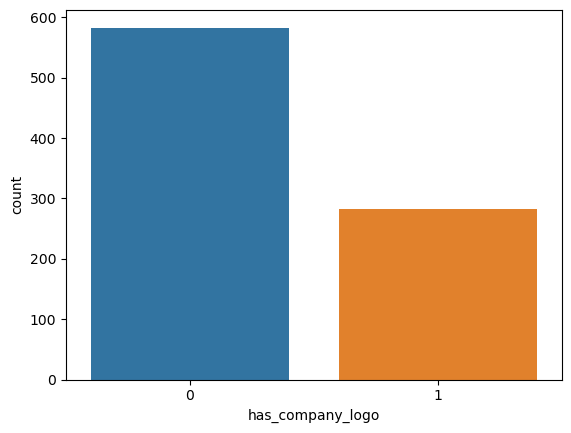

In [62]:
sns.countplot(x='has_company_logo',data=Job_postings_fraud)

__From the above plot it is clear most of fraudulent job postings comes from the unexisting/unregistered companies which are not having their very own logo/trademark__

# Has Questions

In [63]:
Job_postings_fraud['has_questions'].value_counts()

0    616
1    250
Name: has_questions, dtype: int64

<Axes: xlabel='has_questions', ylabel='count'>

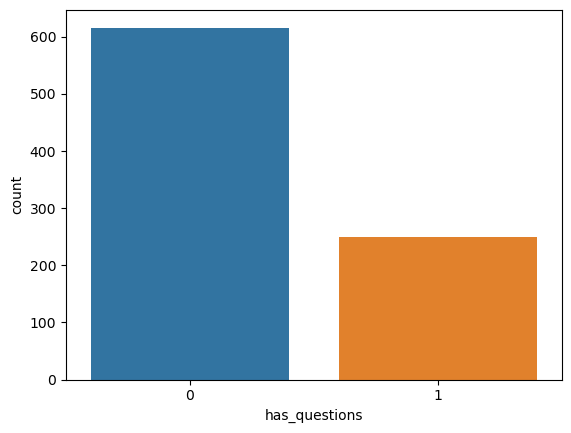

In [64]:
sns.countplot(x='has_questions',data=Job_postings_fraud)

__From the above plot it is clear companies with fake job postings did'nt talk about the facility of questoning which will be useful to the individual who is applying for the post__

# Imputing Missing values

In [65]:
Job_postings_.isnull().sum()

title                      0
department             11252
company_profile            0
description                0
requirements               0
benefits                   0
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3257
required_experience     6797
required_education      7821
industry                4655
function                6193
fraudulent                 0
Location                   0
dtype: int64

__Here all the features which were having missing values can be considered as text data and combined together as it makes textual informaton about the job posted__

__So here i'm imputing them with the spaces__

In [66]:
Filling_values={'department': ' ','employment_type': ' ','required_experience':'  ','required_education': ' ','industry':' ','function':' '}

In [67]:
Job_postings_.fillna(value=Filling_values,inplace=True)

In [68]:
Job_postings_.isnull().sum()

title                  0
department             0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
Location               0
dtype: int64

# Text Pre processing

In [69]:
Job_postings_

,title,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Location
0,Marketing Intern,Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0,US
3,Account Executive - Washington DC,Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,Sales,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,,Computer Software,Sales,0,CA
17876,Payroll Accountant,Accounting,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US
17877,Project Cost Control Staff Engineer - Cost Con...,,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,0,0,0,Full-time,,,,,0,US
17878,Graphic Designer,,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0,NG


In [70]:
#Creating one single feature which contains the whole text information
Job_postings_['Text information']=Job_postings['title']+' '+Job_postings_['department']+' '+Job_postings_['company_profile']+' '+Job_postings_['description']+' '+Job_postings_['requirements']
Job_postings_['benefits']+' '+Job_postings_['employment_type']+Job_postings_['required_experience']+' '+Job_postings_['required_education']+' '+Job_postings_['industry']+' '+Job_postings_['function']

0                            OtherInternship     Marketing
1        What you will get from usThrough being part of...
2                                                         
3        Our culture is anything but corporate—we have ...
4        Full Benefits Offered Full-timeMid-Senior leve...
                               ...                        
17875    What can you expect from us?We have an open cu...
17876    Health &amp; WellnessMedical planPrescription ...
17877                                    Full-time        
17878    Competitive salary (compensation will be based...
17879      Full-timeMid-Senior level   Computer Softwar...
Length: 17534, dtype: object

In [71]:
#Collecting the list of features that can be dropped after concatenation
cols_to_drop=['title','department','company_profile','description','requirements','benefits','employment_type','required_experience','required_education','industry','function','Location']

In [72]:
#copying the new Dataset
F_data=Job_postings_.drop(columns=cols_to_drop,axis=1)

In [73]:
F_data

,telecommuting,has_company_logo,has_questions,fraudulent,Text information
0,0,1,0,0,"Marketing Intern Marketing We're Food52, and w..."
1,0,1,0,0,Customer Service - Cloud Video Production Succ...
2,0,1,0,0,Commissioning Machinery Assistant (CMA) Valo...
3,0,1,0,0,Account Executive - Washington DC Sales Our pa...
4,0,1,1,0,Bill Review Manager SpotSource Solutions LLC...
...,...,...,...,...,...
17875,0,1,1,0,Account Director - Distribution Sales Vend is...
17876,0,1,1,0,Payroll Accountant Accounting WebLinc is the e...
17877,0,0,0,0,Project Cost Control Staff Engineer - Cost Con...
17878,0,0,1,0,Graphic Designer Nemsia Studios is looking...


# Natural Language Processing

In [74]:
#Converting text information into lower case through iteration
for index, row in F_data.iterrows():
    F_data.at[index, 'Text information'] = row['Text information'].lower()

In [75]:
F_data['Text information']

0        marketing intern marketing we're food52, and w...
1        customer service - cloud video production succ...
2        commissioning machinery assistant (cma)   valo...
3        account executive - washington dc sales our pa...
4        bill review manager   spotsource solutions llc...
                               ...                        
17875    account director - distribution  sales vend is...
17876    payroll accountant accounting weblinc is the e...
17877    project cost control staff engineer - cost con...
17878    graphic designer     nemsia studios is looking...
17879    web application developers engineering vend is...
Name: Text information, Length: 17534, dtype: object

In [76]:
#Initialising the object for both the stemming techniques
ps=PorterStemmer()
LM=WordNetLemmatizer()

In [77]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/raviirt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

__Stemming was preferred to lemmatization__

In [78]:
Processed_Text = []#Creating empty list to store the final processed text
for index, row in F_data.iterrows():#idea is to iterate through each text sample through indexing.
    text = F_data.at[index, 'Text information']#Retrieving the text
    cleaned_text = re.sub('[^a-zA-Z]', ' ', text)#substituting all the unwanted and special characters with spaces.
    cleaned_text = cleaned_text.split()
    stemmed_text = []
    for word in cleaned_text:
        if word not in stopwords.words('english'):
            stemmed_word = ps.stem(word)
            stemmed_text.append(stemmed_word)
    #stemming was performed to the after the split to all the words other than stop words.
    cleaned_text = ' '.join(stemmed_text)
    Processed_Text.append(cleaned_text)


In [79]:
#This List contains the cleaned texts which contains no special characters,stopwords and with stemming performed.
#Now the text is fit to perform Vectorization
Processed_Text

['market intern market food creat groundbreak award win cook site support connect celebr home cook give everyth need one place top editori busi engin team focus use technolog find new better way connect peopl around specif food interest offer superb highli curat inform food cook attract talent home cook contributor countri also publish well known profession like mario batali gwyneth paltrow danni meyer partnership whole food market random hous food name best food websit jame beard foundat iacp featur new york time npr pando daili techcrunch today show locat chelsea new york citi food fast grow jame beard award win onlin food commun crowd sourc curat recip hub current interview full part time unpaid intern work small team editor execut develop new york citi headquart reproduc repackag exist food content number partner site huffington post yahoo buzzfe variou content manag systemsresearch blog websit provis food affili programassist day day affili program support screen affili assist aff

# Vectorization

__Here i preferref TFIDF to Bag of words__

In [80]:
#Initialising the object for tfidf
#setting the maximum no:of features to 7000 i.e first 7000 most frequently occuring words
#setting ngram to default value where unigrams,bigrams and trigrams are considered as features
tf=TfidfVectorizer(max_features=7000,ngram_range=(1,3))
#Hereby setting the predictor features.
X=tf.fit_transform(Processed_Text).toarray()

In [81]:
tf.get_feature_names_out()

array(['aa', 'aabbf', 'aabbf ca', ..., 'zealand', 'zero', 'zone'],
      dtype=object)

In [82]:
tf.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 7000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [83]:
#So 7000 columns i.e features
X.shape

(17534, 7000)

In [84]:
#Setting the target variable
y=F_data['fraudulent']

In [85]:
y.shape

(17534,)

In [118]:
fraudulent_texts=F_data[F_data['fraudulent']==1]['Text information']

In [123]:
fraudulent_texts=' '.join(fraudulent_texts)

In [183]:
words=cleaned_text.split()

In [184]:
words

['web',
 'applic',
 'develop',
 'engin',
 'vend',
 'look',
 'awesom',
 'new',
 'talent',
 'come',
 'join',
 'us',
 'work',
 'awesom',
 'team',
 'awesom',
 'thing',
 'gener',
 'awesom',
 'learn',
 'us',
 'blog',
 'meet',
 'team',
 'twitter',
 'facebook',
 'linkedinawesom',
 'spaceour',
 'brand',
 'new',
 'auckland',
 'offic',
 'space',
 'locat',
 'nuffield',
 'street',
 'newmarket',
 'surround',
 'custom',
 'industri',
 'love',
 'huge',
 'open',
 'shini',
 'new',
 'great',
 'meet',
 'room',
 'space',
 'casual',
 'work',
 'environ',
 'plenti',
 'space',
 'host',
 'awesom',
 'event',
 'cubicl',
 'plenti',
 'space',
 'whiteboard',
 'meet',
 'room',
 'also',
 'great',
 'cafe',
 'retail',
 'space',
 'front',
 'hous',
 'manag',
 'take',
 'care',
 'visitor',
 'fellow',
 'vender',
 'like',
 'auckland',
 'melbourn',
 'offic',
 'surround',
 'retail',
 'great',
 'wee',
 'space',
 'equip',
 'tini',
 'hous',
 'awesom',
 'cardboard',
 'cutout',
 'anim',
 'toronto',
 'offic',
 'locat',
 'right',
 'hea

In [185]:
word_count=Counter(words)

In [186]:
word_count.items()

dict_items([('web', 2), ('applic', 3), ('develop', 3), ('engin', 2), ('vend', 7), ('look', 4), ('awesom', 7), ('new', 5), ('talent', 4), ('come', 2), ('join', 1), ('us', 5), ('work', 15), ('team', 7), ('thing', 2), ('gener', 2), ('learn', 1), ('blog', 1), ('meet', 3), ('twitter', 2), ('facebook', 1), ('linkedinawesom', 1), ('spaceour', 1), ('brand', 1), ('auckland', 4), ('offic', 4), ('space', 6), ('locat', 3), ('nuffield', 1), ('street', 1), ('newmarket', 1), ('surround', 2), ('custom', 3), ('industri', 1), ('love', 1), ('huge', 2), ('open', 3), ('shini', 1), ('great', 5), ('room', 2), ('casual', 1), ('environ', 2), ('plenti', 2), ('host', 1), ('event', 1), ('cubicl', 1), ('whiteboard', 1), ('also', 2), ('cafe', 1), ('retail', 6), ('front', 1), ('hous', 3), ('manag', 1), ('take', 2), ('care', 1), ('visitor', 1), ('fellow', 1), ('vender', 1), ('like', 8), ('melbourn', 2), ('wee', 1), ('equip', 1), ('tini', 1), ('cardboard', 1), ('cutout', 1), ('anim', 1), ('toronto', 1), ('right', 1), 

In [187]:
Sorted_word_counts = dict(sorted(word_count.items(), key=lambda item: item[1], reverse=True))

In [192]:
Sorted_word_counts

{'work': 15,
 'like': 8,
 'want': 8,
 'vend': 7,
 'awesom': 7,
 'team': 7,
 'space': 6,
 'retail': 6,
 'new': 5,
 'us': 5,
 'great': 5,
 'look': 4,
 'talent': 4,
 'auckland': 4,
 'offic': 4,
 'tech': 4,
 'life': 4,
 'use': 4,
 'applic': 3,
 'develop': 3,
 'meet': 3,
 'locat': 3,
 'custom': 3,
 'open': 3,
 'hous': 3,
 'start': 3,
 'peopl': 3,
 'hard': 3,
 'lead': 3,
 'world': 3,
 'get': 3,
 'know': 3,
 'web': 2,
 'engin': 2,
 'come': 2,
 'thing': 2,
 'gener': 2,
 'twitter': 2,
 'surround': 2,
 'huge': 2,
 'room': 2,
 'environ': 2,
 'plenti': 2,
 'also': 2,
 'take': 2,
 'melbourn': 2,
 'greatest': 2,
 'base': 2,
 'point': 2,
 'softwar': 2,
 'touch': 2,
 'make': 2,
 'stack': 2,
 'go': 2,
 'product': 2,
 'best': 2,
 'latest': 2,
 'delight': 2,
 'member': 2,
 'technolog': 2,
 'balanc': 2,
 'lot': 2,
 'project': 2,
 'year': 2,
 'understand': 2,
 'total': 2,
 'write': 2,
 'need': 2,
 'face': 2,
 'join': 1,
 'learn': 1,
 'blog': 1,
 'facebook': 1,
 'linkedinawesom': 1,
 'spaceour': 1,
 'brand'

# Splitting the data into train and test dataset

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Performing Random oversampling

__We know it's a unbalanced dataset so before performing training and predictions we need to balance the dataset__

__Here i decided to go with oversampling instead of undersampling because of which i might lost heavy amount of data as the minority samples are way too less in number__

__Therefore performing Over sampling__

In [87]:
#Creating an object for Randomoversampler
ROS=RandomOverSampler()
#creating an object for Smotetomek
SM=SMOTETomek(random_state=42)

In [88]:
#Checking the shape before sampling
print(X_train.shape,y_train.shape)

(11747, 7000) (11747,)


In [89]:
X_sampled,y_sampled=ROS.fit_resample(X_train,y_train)

In [90]:
#Checking the shape after sampling
print(X_sampled.shape,y_sampled.shape)

(22370, 7000) (22370,)


__From above it is clear that samples got added up__

__As we used random sampler it just duplicates the minority samples and adds up__

__If i use Smot then it'll use kNN technique to retrive the complexity amongst the samples and used it up to generate new minority samples__

__Now the training samples are ready for training the algorithm__

# Naive bayes Classifier

In [91]:
#Creating the object for Multinomial Naive bayes
Classifier=MultinomialNB()

In [92]:
#Fitting the sampled train datasets
Classifier.fit(X_sampled,y_sampled)

MultinomialNB()

In [93]:
#Predictions using test dataset
Predictions=Classifier.predict(X_test)

# Naive Bayes Evaluation

In [95]:
confusion_matrix(Predictions,y_test)

array([[4786,   19],
       [ 716,  266]])

In [107]:
Evaluation_report_NB=classification_report(Predictions,y_test)

In [108]:
print(Evaluation_report_NB)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      4805
           1       0.93      0.27      0.42       982

    accuracy                           0.87      5787
   macro avg       0.90      0.63      0.67      5787
weighted avg       0.88      0.87      0.84      5787



# Insights from the classification report (Naive Bayes Classifier)

__Eventhough the model performed good there's still need for betterment in terms of predictions__

__Looking at the recall score for positve which is less it is clear that model failed to predict most number of positive cases as positive__

# Random forest Classifier

In [99]:
RFR=RandomForestClassifier()
RFR.fit(X_sampled,y_sampled)
RFR_PRED=RFR.predict(X_test)

In [100]:
confusion_matrix(RFR_PRED,y_test)

array([[5497,  120],
       [   5,  165]])

In [167]:
Evaluation_report_RF=classification_report(RFR_PRED,y_test)
print(Evaluation_report_RF)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5617
           1       0.58      0.97      0.73       170

    accuracy                           0.98      5787
   macro avg       0.79      0.97      0.86      5787
weighted avg       0.99      0.98      0.98      5787



# Insights from the classification report (Random Forest Classifier)

__False positives are high when compared to the previous model__

__High recall and less precision for positive samples indicates the model is really good at predicting positive samples but also generating false positives__

# XGboost Classifier

In [102]:
Xgb=XGB.XGBClassifier(objective="binary:logistic")

In [103]:
Xgb.fit(X_sampled,y_sampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [104]:
Xgb_predictions=Xgb.predict(X_test)

In [105]:
confusion_matrix(Xgb_predictions,y_test)

array([[5465,   80],
       [  37,  205]])

In [193]:
Evaluation_report_Xgb=classification_report(Xgb_predictions,y_test)
print(Evaluation_report_Xgb)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5545
           1       0.72      0.85      0.78       242

    accuracy                           0.98      5787
   macro avg       0.86      0.92      0.88      5787
weighted avg       0.98      0.98      0.98      5787



# Insights from the classification report (Xgboost Classifier)

__Seems like XGboost classifier performed better in predicting the positive cases__

__Looking at the slight improvement in the f1-score for positive samples indicates it avoids unwanted false positives__

# KNN classifier

In [170]:
Knn=KNeighborsClassifier(n_neighbors=1)

In [171]:
Knn.fit(X_sampled,y_sampled)

KNeighborsClassifier(n_neighbors=1)

In [172]:
Predictions_Knn=Knn.predict(X_test)

In [173]:
Evaluation_report_Knn=classification_report(Predictions_Knn,y_test)
print(Evaluation_report_Knn)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5537
           1       0.74      0.85      0.79       250

    accuracy                           0.98      5787
   macro avg       0.87      0.92      0.89      5787
weighted avg       0.98      0.98      0.98      5787



# K Value Selection

In [168]:
Error_rate=[]
for i in range(1,15):
    Knn=KNeighborsClassifier(n_neighbors=i)
    Knn.fit(X_sampled,y_sampled)
    pred=Knn.predict(X_test)
    Error_rate.append(np.mean(pred!=y_test))

Text(0.5, 0, 'K value')

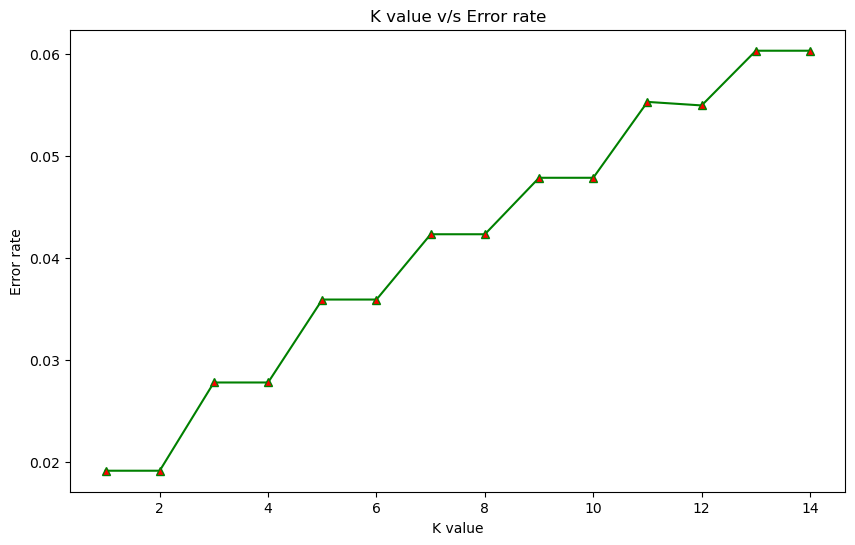

In [180]:
plt.figure(figsize=(10,6))
plt.plot(range(1,15),Error_rate,color='green',marker='^',markerfacecolor='red')
plt.title('K value v/s Error rate')
plt.ylabel('Error rate')
plt.xlabel('K value')

__From the above plot it is clear that Error rate is increasing with increase in K value__

__Therefor proceeding further with K as 1__

# Conclusion

__From the above analysis and model predictions it is evident that the field,departments and countries with most number of job postings suffers from this kind of fraudulent postings which is inevitable__

__So it is better to have some red flags like checking for absence of company logo and their accountability status as we found most of the fraudulent companies do not possess these__

__When it comes to text information from the job description the entire text together might be helpful in predicting the value of a job posting__

__Coming to Model selection for the prediction depends on the priority amongst precision and recall(as i considered these two)__